# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from numba import njit, cuda

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


In [5]:
x_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Defining the functions(GENERAL)

## Parameter initialization

In [6]:
def params_init_seeded(seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(20,784) - 0.5
  b1 = np.random.rand(20,1) - 0.5
  W2 = np.random.rand(10,20) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

In [7]:
def params_init():

  W1 = np.random.rand(20,784) - 0.5
  b1 = np.random.rand(20,1) - 0.5
  W2 = np.random.rand(10,20) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

## Other generic functions egs-loss

In [8]:
def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [9]:

def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre + 10**(-16))), axis = 0)
  return loss

## Forward pass

In [10]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

## Param update

In [11]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

# Back propagation

In [12]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [13]:
def batch_grad_descent(X,Y,iter, lr, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      #X1, Y1 = X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')
      if (i+1)%20==0:
        plt.figure()
        plt.subplot(2,2 ,1)
        plt.hist(W1.flatten(), bins = 30)
        plt.subplot(2,2 ,2)
        plt.hist(W2.flatten(), bins = 30)
        plt.subplot(2,2, 3)
        plt.hist(b1.flatten(), bins = 30)
        plt.subplot(2,2, 4)
        plt.hist(b2.flatten(), bins = 30)

  return W1, b1, W2, b2, train_acc, val_acc, train_loss, val_loss, sum_weights


Params Initialised
Iteration: 1
Train accuracy: 64.52698412698412
Val accuracy: 65.17142857142856
Iteration: 2
Train accuracy: 68.88888888888889
Val accuracy: 69.17142857142858
Iteration: 3
Train accuracy: 71.2031746031746
Val accuracy: 71.67142857142858
Iteration: 4
Train accuracy: 72.99365079365079
Val accuracy: 73.65714285714286
Iteration: 5
Train accuracy: 74.71904761904761
Val accuracy: 75.35714285714286
Iteration: 6
Train accuracy: 76.16190476190476
Val accuracy: 76.57142857142857
Iteration: 7
Train accuracy: 77.15079365079364
Val accuracy: 77.51428571428572
Iteration: 8
Train accuracy: 77.92222222222223
Val accuracy: 78.17142857142856
Iteration: 9
Train accuracy: 78.57936507936508
Val accuracy: 78.7
Iteration: 10
Train accuracy: 79.15238095238095
Val accuracy: 79.17142857142856
Iteration: 11
Train accuracy: 79.5968253968254
Val accuracy: 79.62857142857143
Iteration: 12
Train accuracy: 79.97460317460317
Val accuracy: 79.87142857142857
Iteration: 13
Train accuracy: 80.352380952380

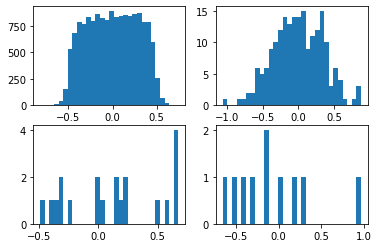

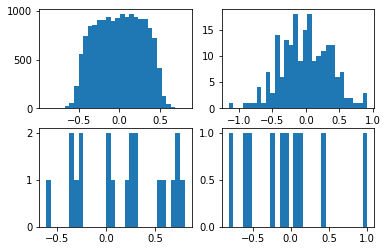

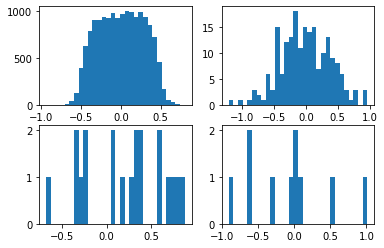

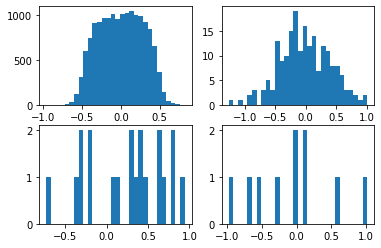

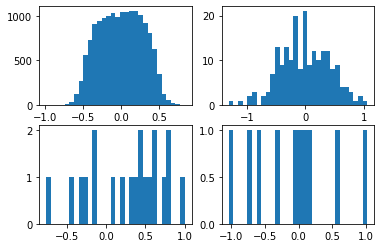

In [86]:
_, _, _, _, train_accBP, val_accBP, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,100, 0.1, print_op=1);

## Adding variabilty

### Generic functions related to variability

In [14]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
#add clipping here
# def roundArbitrary(weightArray, step):
#   weightArrayDiv = weightArray / step
#   weightArrayDiv = np.round(weightArrayDiv)
#   return weightArrayDiv*step
def roundArbitrary(weightArray, step, wRange):#updates function with clipping
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

In [15]:
def getVth(mu, sigma, shape):
  #last dimension represents the binary rep for each weight
  print(shape)
  return np.random.normal(loc=mu, scale=sigma, size=shape) #each bit is represented by an sram so we need those many vth values for each mosfet in this set

In [16]:
def initMosParam(shape, mu, sigma, vDD, precision, k=100):
    #modelling both Ion and Ioff  = I0*exp(Vgs-Vth/(eta*kB*T)),
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)
    I0On = 1e+06
    I0Off = I0On/k
    #eta = 
    #kB = 1.3806452e10-23
    #T = 300
    VT = 0.026*1.5#should be eqaul to eta x kB x T

    #Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    Vth[Vth<=0] = 10e-10

    #iOn = ((vDD - Vth)**2)*I0On#scaling the current according to Ioff values arbitraryfor now!!
    iOn = I0On * np.exp((0 - Vth)/(VT))
    #iOn = I0On * np.ones_like(Vth)



    #iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))
    iOnNominal = np.sum(iOn)/(dim1*dim2*precision)
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    #iOff = np.random.uniform(low=0, high=1e-8, size = sizeI)#no negative value
    iOff = I0Off * np.exp((0 - Vth)/(VT))
    #iOff = I0Off * np.ones_like(Vth)
    return (iOn, iOnNominal, iOff)

In [17]:
def clippedWeight(weightArray, precision, step, discreteSteps):
    return np.multiply(np.sign(weightArray), np.digitize(np.abs(weightArray), discreteSteps))*step

In [18]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps, wRange):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  #clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights
  #updating the above to the actual round function.
  clippedWeightIndexArray = (roundArbitrary(weightArray, step, wRange)/step).astype(np.int64)
  clippedWeightIndexArray = np.abs(clippedWeightIndexArray)

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray +=  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)

  
  analogWeightArray  = np.multiply(np.sign(weightArray), analogWeightArray)

  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [19]:
# refer to https://stackoverflow.com/questions/9958506/element-wise-string-concatenation-in-numpy

## NEED TO CORRECT IT FOR A NEGATIVE VALUES OF THE WEIGHT ARRAY!!!!
def weigthBitArray(weightArray, precision, discreteSteps):
    clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights

    iniArr = np.where(np.bitwise_and(clippedWeightIndexArray, 2**0)>=1, '1', '0') #array of bits at level 0 (2^0)

    for j in range(1, precision):
        iniArr = np.core.defchararray.add(np.where(np.bitwise_and(clippedWeightIndexArray, 2**j)>=1, '1', '0'), iniArr)
    return iniArr

In [20]:
def batchGDCompOCUp(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []
  W1comp = []

  W1, b1, W2, b2 = params_init_seeded(seed=2)

  W1bp, b1bp, W2bp, b2bp = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  

  W1bpvar, b1bpvar, W2bpvar, b2bpvar = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  W1bpvar = roundArbitrary(W1bpvar, step, wRange)#weights have to maintained as their digitized versions
  b1bpvar = roundArbitrary(b1bpvar, step, wRange)
  W2bpvar = roundArbitrary(W2bpvar, step, wRange)
  b2bpvar = roundArbitrary(b2bpvar, step, wRange)


  W1Currents = initMosParam((20, 784), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((20, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      

      
      W1varocwp = weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange)
      b1varocwp = weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange)
      W2varocwp = weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange)
      b2varocwp = weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange)

      #doing the weight perturbation pass first
      Z1, A1, Z2, A2 = forward(X1, W1varocwp, b1varocwp, W2varocwp,b2varocwp) 
      #print(A2)
      print(f"BP with Var Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1), 3)}", end = "\r", flush = True)
      #lossBeforePert = np.sum(crossEntropy(one_hot_encoding(Y1), A2))


      dW1bpvar, db1bpvar, dW2bpvar, db2bpvar = backprop(Z1, A1, Z2, A2, W1varocwp, W2varocwp, X1, Y1)
      #print(dW1wp)
      #print(W1roundwp/step)

      # dW1roundbpvar = roundArbitrary(dW1bpvar, step, wRange)#weights have to maintained as their digitized versions
      # db1roundbpvar = roundArbitrary(db1bpvar, step, wRange)
      # dW2roundbpvar = roundArbitrary(dW2bpvar, step, wRange)
      # db2roundbpvar = roundArbitrary(db2bpvar, step, wRange)
      



      W1bpvar, b1bpvar, W2bpvar, b2bpvar = param_update(W1bpvar, b1bpvar, W2bpvar,b2bpvar, dW1bpvar, db1bpvar, dW2bpvar, db2bpvar, lr = lrNP)
      W1bpvar = roundArbitrary(W1bpvar, step, wRange)#weights have to maintained as their digitized versions
      b1bpvar = roundArbitrary(b1bpvar, step, wRange)
      W2bpvar = roundArbitrary(W2bpvar, step, wRange)
      b2bpvar = roundArbitrary(b2bpvar, step, wRange)


      #doing the back propagation for the same data set sample

      Z1, A1, Z2, A2 = forward(X1, W1bp, b1bp, W2bp, b2bp) 
      print(f"                                                                   BP(Software) Iter {i+1} -> sub iter {j} : {accuracy(predictions(A2), Y1)}", end = "\r", flush = True)

      #dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)
      #loss = np.sum(crossEntropy(one_hot_encoding(Y1), A2))
      #dW1quantwp, db1quantwp, dW2quantwp, db2quantwp = WP(W1quantwp, b1quantwp, W2quantwp, b2quantwp, pert=pert, lossBeforePert=loss, X=X1, y=Y1)
      dW1bp, db1bp, dW2bp, db2bp = backprop(Z1, A1, Z2, A2, W1bp, W2bp, X1, Y1)
      W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp, b2bp,  dW1bp,  db1bp, dW2bp, db2bp,  lr = lrNP)


    # #   dW1quantround = roundArbitrary(dW1quantwp, step, wRange)#weights have to maintained as their digitized versions
    # #   db1quantround = roundArbitrary(db1quantwp, step, wRange)
    # #   dW2quantround = roundArbitrary(dW2quantwp, step, wRange)
    # #   db2quantround = roundArbitrary(db2quantwp, step, wRange)


    
      # if (i==0 or i==1)and (j==0 or j==1):
        
      #   plt.figure(figsize=(16, 16))
      #   plt.gcf().set_dpi(300)
      #   plt.suptitle(f"Intial model plots at iter = {i} epcoch {j} prec = {precision} sig = {sigma}  rat = {onoff}")
      #   plt.subplot(2,2,1)
      #   plt.plot(W1bp.flatten(), W1bpvar.flatten(), '.')
      #   plt.plot(W1bp.flatten(), W1bp.flatten(), 'r', alpha = 0.3)
      #   plt.xlim([-1, 1])
      #   plt.ylim([-1, 1])
      #   plt.title(f"Software W1 vs W1 calc with variability included ")
      #   plt.xlabel("Sofware")
      #   plt.ylabel("Var")
      #   plt.subplot(2,2,2)
      #   plt.plot(dW1bp.flatten(), dW1bpvar.flatten(), '.')
      #   plt.plot(dW1bp.flatten(), dW1bp.flatten(), 'r', alpha = 0.3)
      #   #plt.plot(dW1bp.flatten(), dW1bp.flatten(), 'g^', alpha = 0.3)
      #   plt.xlim([-0.07, 0.07])
      #   plt.ylim([-0.07, 0.07])
      #   plt.title(f"Weight updates in software vs variability")
      #   plt.xlabel("Sofware")
      #   plt.ylabel("Var")
      #   plt.subplot(2,2,3)
      #   plt.plot(dW1bp.flatten(), dW1roundbpvar.flatten(), '.')
      #   plt.plot(dW1bp.flatten(), dW1bp.flatten(), 'r', alpha = 0.3)
      #   plt.xlim([-0.07, 0.07])
      #   plt.ylim([-0.07, 0.07])
      #   plt.title(f"Weight updates in software vs variability(dW1 rounded)")
      #   plt.xlabel("Sofware")
      #   plt.ylabel("Var")
      #   plt.subplot(2,2,4)
      #   plt.plot(dW1bpvar.flatten(), dW1roundbpvar.flatten(), 'k.', alpha = 0.3)
      #   plt.xlim([-0.07, 0.07])
      #   plt.ylim([-0.07, 0.07])
      #   plt.title(f"dW1 vs its quantization")
      #   plt.xlabel("Sofware")
      #   plt.ylabel("Var")
    

    # if i==iter-1:

    #   plt.figure(figsize=(16, 8))
    #   plt.gcf().set_dpi(300)
    #   plt.suptitle(f"Final trained model plots prec = {precision} sig = {sigma}  rat = {onoff}")
    #   plt.subplot(121)
    #   plt.plot(W1bp.flatten(), W1bpvar.flatten(), '.')
    #   plt.plot(W1bp.flatten(), W1bp.flatten(), 'r', alpha = 0.3)
    #   plt.xlim([-1, 1])
    #   plt.ylim([-1, 1])
    #   plt.title(f"Final weights")
    #   plt.xlabel("Sofware")
    #   plt.ylabel("Var")
    #   plt.subplot(122)
    #   plt.plot(dW1bp.flatten(), dW1roundbpvar.flatten(), '.')
    #   plt.plot(dW1bp.flatten(), dW1bp.flatten(), 'r', alpha = 0.3)
    #   plt.xlim([-0.07, 0.07])
    #   plt.ylim([-0.07, 0.07])
    #   plt.title(f"Final weight updates dW1")
    #   plt.xlabel("Sofware")
    #   plt.ylabel("Var")



    if (i+1)%(print_op) == 0:

      _, _, _, A2_train = forward(X, W1bp, b1bp, W2bp, b2bp)
      _, _, _, A2_train_bp = forward(X, weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, Y.shape[0]):

       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append([train_score, accuracy(predictions(A2_train_bp), Y)])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,  A2_val = forward(x_val, W1bp, b1bp, W2bp, b2bp)
      _, _, _, A2_val_bp = forward(x_val,weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append([ val_score, accuracy(predictions(A2_val_bp), y_val)])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy(software BP): {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}:#########################:Train Acc BP var::{round(accuracy(predictions(A2_train_bp), Y), 3)} Val Acc BP var::{round(accuracy(predictions(A2_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

In [63]:
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
iter=1
lrBP=0.1
lrNP=0.1
pert=0.1
mu = 0.7
sigma = 0.07943282
vDD = 5
precision = 16#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
batchGDCompOCUp(x_train,y_train,60, lrBP, lrNP, step, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff = 10000,print_op=10);

Params Initialised
Iteration: 10::Train accuracy(software BP): 78.578::Val accuracy: 78.857:#########################:Train Acc BP var::58.34 Val Acc BP var::58.557
Iteration: 20::Train accuracy(software BP): 82.095::Val accuracy: 82.243:#########################:Train Acc BP var::64.973 Val Acc BP var::64.057
Iteration: 30::Train accuracy(software BP): 83.667::Val accuracy: 83.414:#########################:Train Acc BP var::59.962 Val Acc BP var::59.9
Iteration: 40::Train accuracy(software BP): 84.637::Val accuracy: 84.171:#########################:Train Acc BP var::65.189 Val Acc BP var::64.4
Iteration: 50::Train accuracy(software BP): 85.27::Val accuracy: 84.814:#########################:Train Acc BP var::64.724 Val Acc BP var::64.543
Iteration: 60::Train accuracy(software BP): 85.73::Val accuracy: 85.443:#########################:Train Acc BP var::68.162 Val Acc BP var::68.371


In [32]:
#Sigma = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
#nf = [10, 100, 1000, 10000, 100000]
#prec = np.array([2,4,6,7, 8,9, 10, 11,12,14, 16])
prec= np.array([10, 11,12,14, 16])
trainAccSoft, trainAccVari1, valAccSoft, valAccVari1 = np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec)))
for j in range(len(Sigma)):
    for k in range(len(prec)):
        noOfLevels = 2**prec[k]- 1 #no of levels of quantization
        #step = round(wRange/noOfLevels, precision)
        step =  wRange/noOfLevels#step size of each of the step after quantization
        #discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
        discreteSteps = [step*i for i in range(0, noOfLevels)] 
        print(f"Training for sig = {Sigma[j]} prec = {prec[k]} step= {step}")
        trainAccVar, valAccVar,_, _, _ = batchGDCompOCUp(x_train,y_train,60, lrBP, lrNP, step, mu, Sigma[j], vDD, prec[k], step, discreteSteps, wRange, onoff = 10000,print_op=10);
        trainAccSoft[j, k] = trainAccVar[-1][0]
        trainAccVari1[j, k] = trainAccVar[-1][1]
        valAccSoft[j, k] = valAccVar[-1][0]
        valAccVari1[j, k] = valAccVar[-1][1]
        time.sleep(5)

Training for sig = 0.07943282347242814 prec = 10 step= 0.0009775171065493646
Params Initialised
Iteration: 10::Train accuracy(software BP): 78.578::Val accuracy: 78.857:#########################:Train Acc BP var::51.792 Val Acc BP var::51.686
Iteration: 20::Train accuracy(software BP): 82.095::Val accuracy: 82.243:#########################:Train Acc BP var::52.975 Val Acc BP var::52.557
Iteration: 30::Train accuracy(software BP): 83.667::Val accuracy: 83.414:#########################:Train Acc BP var::52.41 Val Acc BP var::51.3
Iteration: 40::Train accuracy(software BP): 84.637::Val accuracy: 84.171:#########################:Train Acc BP var::56.567 Val Acc BP var::55.914
Iteration: 50::Train accuracy(software BP): 85.27::Val accuracy: 84.814:#########################:Train Acc BP var::55.306 Val Acc BP var::54.843
Iteration: 60::Train accuracy(software BP): 85.73::Val accuracy: 85.443:#########################:Train Acc BP var::56.733 Val Acc BP var::56.457
Training for sig = 0.079432

In [35]:
trainAccVari1

array([[56.73333333, 57.76825397, 63.66825397, 67.88412698, 71.48412698],
       [64.97301587, 58.72698413, 67.39206349, 76.27777778, 75.67301587],
       [62.8031746 , 73.53968254, 73.57619048, 72.89365079, 76.95555556],
       [66.88095238, 80.41587302, 81.49047619, 79.13809524, 80.11111111],
       [79.73174603, 78.3968254 , 81.30793651, 79.12857143, 80.66825397],
       [80.46507937, 81.68571429, 81.34920635, 84.01746032, 83.46507937],
       [82.1984127 , 81.87936508, 83.74285714, 84.38571429, 84.70952381],
       [79.05873016, 82.15555556, 84.3968254 , 84.84603175, 85.28095238],
       [81.95555556, 84.13968254, 84.73015873, 84.83650794, 85.18412698]])

In [36]:
valAccVari1

array([[56.45714286, 58.14285714, 63.62857143, 67.21428571, 71.02857143],
       [64.1       , 58.45714286, 67.41428571, 75.84285714, 75.58571429],
       [63.17142857, 73.84285714, 73.91428571, 72.78571429, 76.68571429],
       [66.72857143, 79.47142857, 81.05714286, 78.54285714, 79.64285714],
       [79.1       , 78.77142857, 81.21428571, 79.27142857, 80.45714286],
       [80.04285714, 81.15714286, 81.21428571, 83.55714286, 83.1       ],
       [81.81428571, 81.57142857, 83.85714286, 83.98571429, 84.54285714],
       [78.61428571, 82.5       , 84.05714286, 84.14285714, 84.97142857],
       [81.92857143, 84.21428571, 84.58571429, 84.3       , 84.78571429]])

In [37]:
#NODe perturbatiion

In [21]:
def NP(pert, lossBeforePert, Z1, A1, Z2, A2, W1, W2, b1, b2, X1, Y1):
  #calculating dw3 and db3
  #print(W2[3])
  #first approximate dZ3
  m = Y1.shape[0]
  #print(Z3.shape)
  lossArrayAfterPertZ2 = np.zeros_like(Z2)
  for i in range(Z2.shape[0]):
    Z2pert = Z2.copy() #creates a local copy of the array since python arrays are sent by reference andnot copy!!
    Z2pert[i, :] +=  pert
    A2pert = softmax(Z2pert)
    #lossArrayAfterPertZ3[i, :] += np.sum(np.square(A3pert-one_hot_encoding(Y1)), axis=0)
    lossArrayAfterPertZ2[i, :] += crossEntropy(one_hot_encoding(Y1), A2pert)


  dZ2 = (lossArrayAfterPertZ2 - lossBeforePert)/pert

  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)



  #calculating the dZ1 and db1
  lossArrayAfterPertZ1 = np.zeros_like(Z1)
  for i in range(Z1.shape[0]):
    Z1pert = Z1.copy()
    Z1pert[i] += pert
    A1pert = relu(Z1pert)
    
    Z2pert = np.matmul(W2,A1pert) + b2 
    A2pert = softmax(Z2pert)
    
    #lossArrayAfterPertZ1[i,:] += np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)
    lossArrayAfterPertZ1[i, :] += crossEntropy(one_hot_encoding(Y1), A2pert)

    
  #print(lossArrayAfterPertZ1)
  dZ1 = (lossArrayAfterPertZ1 - lossBeforePert)/pert

  dW1 = 1/m*np.matmul(dZ1,X1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1

  return dW1, db1, dW2, db2

In [22]:
def batchGDCompOCNP(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []
  W1comp = []

  W1, b1, W2, b2 = params_init_seeded(seed=2)
  #W1, b1, W2, b2 = params_init()

  W1bp, b1bp, W2bp, b2bp = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  

  W1bpvar, b1bpvar, W2bpvar, b2bpvar = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  W1bpvar = roundArbitrary(W1bpvar, step, wRange)#weights have to maintained as their digitized versions
  b1bpvar = roundArbitrary(b1bpvar, step, wRange)
  W2bpvar = roundArbitrary(W2bpvar, step, wRange)
  b2bpvar = roundArbitrary(b2bpvar, step, wRange)


  W1Currents = initMosParam((20, 784), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((20, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      

      
      W1varocwp = weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange)
      b1varocwp = weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange)
      W2varocwp = weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange)
      b2varocwp = weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange)

      #doing the weight perturbation pass first
      Z1, A1, Z2, A2 = forward(X1, W1varocwp, b1varocwp, W2varocwp,b2varocwp) 
      #print(A2)
      print(f"BP with Var Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1), 3)}", end = "\r", flush = True)
      lossBeforePert = crossEntropy(one_hot_encoding(Y1), A2)


      dW1bpvar, db1bpvar, dW2bpvar, db2bpvar = NP(pert, lossBeforePert, Z1, A1, Z2, A2, W1varocwp, W2varocwp, b1varocwp, b2varocwp, X1, Y1)
      #print(dW1wp)
      #print(W1roundwp/step)

      # dW1roundbpvar = roundArbitrary(dW1bpvar, step, wRange)#weights have to maintained as their digitized versions
      # db1roundbpvar = roundArbitrary(db1bpvar, step, wRange)
      # dW2roundbpvar = roundArbitrary(dW2bpvar, step, wRange)
      # db2roundbpvar = roundArbitrary(db2bpvar, step, wRange)
      



      W1bpvar, b1bpvar, W2bpvar, b2bpvar = param_update(W1bpvar, b1bpvar, W2bpvar,b2bpvar, dW1bpvar, db1bpvar, dW2bpvar, db2bpvar, lr = lrNP)
      W1bpvar = roundArbitrary(W1bpvar, step, wRange)#weights have to maintained as their digitized versions
      b1bpvar = roundArbitrary(b1bpvar, step, wRange)
      W2bpvar = roundArbitrary(W2bpvar, step, wRange)
      b2bpvar = roundArbitrary(b2bpvar, step, wRange)


      #doing the back propagation for the same data set sample

      # Z1, A1, Z2, A2 = forward(X1, W1bp, b1bp, W2bp, b2bp) 
      # print(f"                                                                   NP(Software) Iter {i+1} -> sub iter {j} : {accuracy(predictions(A2), Y1)}", end = "\r", flush = True)

      # #dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)
      # loss = crossEntropy(one_hot_encoding(Y1), A2)
      # #dW1quantwp, db1quantwp, dW2quantwp, db2quantwp = WP(W1quantwp, b1quantwp, W2quantwp, b2quantwp, pert=pert, lossBeforePert=loss, X=X1, y=Y1)
      # dW1bp, db1bp, dW2bp, db2bp = NP(pert, loss, Z1, A1, Z2, A2, W1bp, W2bp, b1bp, b2bp, X1, Y1)
      # W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp, b2bp,  dW1bp,  db1bp, dW2bp, db2bp,  lr = lrNP)




#     # #   dW1quantround = roundArbitrary(dW1quantwp, step, wRange)#weights have to maintained as their digitized versions
#     # #   db1quantround = roundArbitrary(db1quantwp, step, wRange)
#     # #   dW2quantround = roundArbitrary(dW2quantwp, step, wRange)
#     # #   db2quantround = roundArbitrary(db2quantwp, step, wRange)
      
    #   if (i==0 or i==1)and (j==0 or j==1):
        
    #     plt.figure(figsize=(16, 16))
    #     plt.gcf().set_dpi(300)
    #     plt.suptitle(f"Intial model plots at iter = {i} epcoch {j} prec = {precision} sig = {sigma}  rat = {onoff}")
    #     plt.subplot(2,2,1)
    #     plt.plot(W1bp.flatten(), W1bpvar.flatten(), '.')
    #     plt.plot(W1bp.flatten(), W1bp.flatten(), 'r', alpha = 0.3)
    #     plt.xlim([-1, 1])
    #     plt.ylim([-1, 1])
    #     plt.title(f"Software W1 vs W1 calc with variability included ")
    #     plt.xlabel("Sofware")
    #     plt.ylabel("Var")
    #     plt.subplot(2,2,2)
    #     plt.plot(dW1bp.flatten(), dW1bpvar.flatten(), '.')
    #     plt.plot(dW1bp.flatten(), dW1bp.flatten(), 'r', alpha = 0.3)
    #     #plt.plot(dW1bp.flatten(), dW1bp.flatten(), 'g^', alpha = 0.3)
    #     plt.xlim([-0.07, 0.07])
    #     plt.ylim([-0.07, 0.07])
    #     plt.title(f"Weight updates in software vs variability")
    #     plt.xlabel("Sofware")
    #     plt.ylabel("Var")
    #     plt.subplot(2,2,3)
    #     plt.plot(dW1bp.flatten(), dW1roundbpvar.flatten(), '.')
    #     plt.plot(dW1bp.flatten(), dW1bp.flatten(), 'r', alpha = 0.3)
    #     plt.xlim([-0.07, 0.07])
    #     plt.ylim([-0.07, 0.07])
    #     plt.title(f"Weight updates in software vs variability(dW1 rounded)")
    #     plt.xlabel("Sofware")
    #     plt.ylabel("Var")
    #     plt.subplot(2,2,4)
    #     plt.plot(dW1bpvar.flatten(), dW1roundbpvar.flatten(), 'k.', alpha = 0.3)
    #     plt.xlim([-0.07, 0.07])
    #     plt.ylim([-0.07, 0.07])
    #     plt.title(f"dW1 vs its quantization")
    #     plt.xlabel("Sofware")
    #     plt.ylabel("Var")
    

    # if i==iter-1:

    #   plt.figure(figsize=(16, 8))
    #   plt.gcf().set_dpi(300)
    #   plt.suptitle("Final trained model plots prec = {precision} sig = {sigma}  rat = {onoff}")
    #   plt.subplot(121)
    #   plt.plot(W1bp.flatten(), W1bpvar.flatten(), '.')
    #   plt.plot(W1bp.flatten(), W1bp.flatten(), 'r', alpha = 0.3)
    #   plt.xlim([-1, 1])
    #   plt.ylim([-1, 1])
    #   plt.title(f"Final weights")
    #   plt.xlabel("Sofware")
    #   plt.ylabel("Var")
    #   plt.subplot(122)
    #   plt.plot(dW1bp.flatten(), dW1roundbpvar.flatten(), '.')
    #   plt.plot(dW1bp.flatten(), dW1bp.flatten(), 'r', alpha = 0.3)
    #   plt.xlim([-0.07, 0.07])
    #   plt.ylim([-0.07, 0.07])
    #   plt.title(f"Final weight updates dW1")
    #   plt.xlabel("Sofware")
    #   plt.ylabel("Var")



    if (i+1)%(print_op) == 0:

      _, _, _, A2_train = forward(X, W1bp, b1bp, W2bp, b2bp)
      _, _, _, A2_train_bp = forward(X, weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, Y.shape[0]):

       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append([train_score, accuracy(predictions(A2_train_bp), Y)])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,  A2_val = forward(x_val, W1bp, b1bp, W2bp, b2bp)
      _, _, _, A2_val_bp = forward(x_val,weightTransformWithVariability(W1bpvar, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1bpvar, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2bpvar, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2bpvar, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append([ val_score, accuracy(predictions(A2_val_bp), y_val)])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy(software BP): {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}:#########################:Train Acc BP var::{round(accuracy(predictions(A2_train_bp), Y), 3)} Val Acc BP var::{round(accuracy(predictions(A2_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

In [70]:
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
iter=1
lrBP=0.1
lrNP=0.1
pert=0.1
mu = 0.7
sigma = 0.07943282
vDD = 5
precision = 16#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
batchGDCompOCNP(x_train,y_train,60, lrBP, lrNP, 0.00001, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff = 10000, print_op=10)
#(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff, print_op=1)

Params Initialised
Iteration: 10::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::60.441 Val Acc BP var::60.529
Iteration: 20::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::65.863 Val Acc BP var::65.1
Iteration: 30::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::66.913 Val Acc BP var::66.729
Iteration: 40::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::62.014 Val Acc BP var::62.314
Iteration: 50::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::62.833 Val Acc BP var::62.986
Iteration: 60::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::69.263 Val Acc BP var::68.286


([[12.2, 60.44126984126984],
  [12.2, 65.86349206349207],
  [12.2, 66.91269841269842],
  [12.2, 62.01428571428571],
  [12.2, 62.83333333333333],
  [12.2, 69.26349206349207]],
 [[12.971428571428573, 60.52857142857143],
  [12.971428571428573, 65.10000000000001],
  [12.971428571428573, 66.72857142857143],
  [12.971428571428573, 62.31428571428571],
  [12.971428571428573, 62.98571428571429],
  [12.971428571428573, 68.28571428571428]],
 [],
 [],
 [])

In [67]:
#Sigma = [0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
#nf = [10, 100, 1000, 10000, 100000]
#prec = np.array([2,4,6,7, 8,9, 10, 11,12,14, 16])
prec= np.array([10, 11,12,14, 16])
trainAccSoftNP, trainAccVari1NP, valAccSoftNP, valAccVari1NP = np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec))), np.zeros((len(Sigma), len(prec)))
for j in range(len(Sigma)):
    for k in range(len(prec)):
        noOfLevels = 2**prec[k]- 1 #no of levels of quantization
        #step = round(wRange/noOfLevels, precision)
        step =  wRange/noOfLevels#step size of each of the step after quantization
        #discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
        discreteSteps = [step*i for i in range(0, noOfLevels)] 
        print(f"Training for sig = {Sigma[j]} prec = {prec[k]} step= {step}")
        trainAccVar, valAccVar,_, _, _ = batchGDCompOCNP(x_train,y_train,60, lrBP, lrNP, 0.00001, mu, Sigma[j], vDD, prec[k], step, discreteSteps, wRange, onoff = 10000, print_op=10)
        trainAccSoftNP[j, k] = trainAccVar[-1][0]
        trainAccVari1NP[j, k] = trainAccVar[-1][1]
        valAccSoftNP[j, k] = valAccVar[-1][0]
        valAccVari1NP[j, k] = valAccVar[-1][1]
        time.sleep(5)

Training for sig = 0.07943282347242814 prec = 10 step= 0.0009775171065493646
Params Initialised
Iteration: 10::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::48.732 Val Acc BP var::47.529
Iteration: 20::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::56.333 Val Acc BP var::56.014
Iteration: 30::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::57.36 Val Acc BP var::56.657
Iteration: 40::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::53.821 Val Acc BP var::54.043
Iteration: 50::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::62.827 Val Acc BP var::62.0
Iteration: 60::Train accuracy(software BP): 12.2::Val accuracy: 12.971:#########################:Train Acc BP var::62.814 Val Acc BP var::61.986
Training for sig = 0.0794328234724281

In [68]:
trainAccVari1NP

array([[62.81428571, 56.53174603, 67.56190476, 66.14444444, 69.84761905],
       [57.37777778, 67.8952381 , 66.82539683, 75.18730159, 70.72380952],
       [71.88730159, 79.15714286, 74.5       , 75.5       , 78.67936508],
       [71.53968254, 78.21428571, 80.0031746 , 81.65555556, 80.15873016],
       [80.17619048, 80.62222222, 81.76507937, 82.75873016, 81.83333333],
       [81.13650794, 81.5047619 , 79.92857143, 84.66190476, 84.28412698],
       [82.1       , 82.63333333, 82.95873016, 83.78571429, 84.62539683],
       [81.8984127 , 84.28571429, 83.81111111, 84.73650794, 83.77777778],
       [82.54285714, 83.96984127, 84.44444444, 85.25238095, 85.38253968]])

In [69]:
valAccVari1NP

array([[61.98571429, 57.7       , 66.45714286, 65.32857143, 68.94285714],
       [57.77142857, 67.34285714, 66.72857143, 74.7       , 70.67142857],
       [71.31428571, 78.55714286, 74.88571429, 75.27142857, 77.88571429],
       [70.92857143, 77.82857143, 79.58571429, 81.65714286, 80.21428571],
       [80.3       , 80.21428571, 81.72857143, 82.21428571, 81.11428571],
       [81.14285714, 81.61428571, 80.4       , 84.51428571, 84.15714286],
       [81.38571429, 83.17142857, 83.11428571, 83.21428571, 84.32857143],
       [81.77142857, 84.02857143, 83.57142857, 84.35714286, 83.84285714],
       [82.74285714, 83.77142857, 84.32857143, 84.78571429, 84.95714286]])

In [23]:
def WPwithVarUp(W1, b1, W2, b2, pert, lossBeforePert, X, y, precision, step, discreteSteps, wRange,  W1Var, b1Var, W2Var, b2Var, W1Currents, b1Currents, W2Currents, b2Currents):
    #assert pert==step #to get increments of '1' in the bit pattern of the weight array
    #!here we chnage perturb only one value
    m = y.shape[0] #m is the number of training examples
    Y = one_hot_encoding(y)
    dW1 = np.zeros_like(W1)
    lossAfterPertW1 = np.zeros_like(W1)
    
    W1pert = W1.copy()
    W1pert += pert
    W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps, wRange)
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1pertLoop = W1Var.copy()
            W1pertLoop[i, j] = W1pertArrTr[i, j]
            #print(W1pertLoop - W1Var)
            #plt.figure()
            #plt.plot(W1Var.flatten(), W1pertLoop.flatten(), '.')
            #plt.title("W1 comp")
            #do the transform only on that perturbed weight and place it in the correct place
            #W1pertArrTr = weightTransformWithVariability(W1pert, W1Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1pertLoop, b1Var, W2Var, b2Var)
            #print(A2pert)
            lossAfterPertW1[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW1 = 1/m * (lossAfterPertW1-lossBeforePert)/pert
    #print(lossAfterPertW1-lossBeforePert)


    db1 = np.zeros_like(b1)
    lossAfterPertb1 = np.zeros_like(b1)

    b1pert = b1.copy()
    b1pert +=pert
    b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps, wRange)

    for i in range(b1.shape[0]):
        b1pertLoop = b1Var.copy()
        b1pertLoop[i]=b1pertArrTr[i]
        #b1pertArrTr = weightTransformWithVariability(b1pert, b1Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1pertLoop, W2Var, b2Var)
        lossAfterPertb1[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db1 = 1/m * (lossAfterPertb1-lossBeforePert)/pert

    
    dW2 = np.zeros_like(W2)
    lossAfterPertW2 = np.zeros_like(W2)

    W2pert = W2.copy()
    W2pert += pert
    W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps, wRange)

    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2pertLoop = W2Var.copy()
            W2pertLoop[i, j] = W2pertArrTr[i, j]
            #W2pertArrTr = weightTransformWithVariability(W2pert, W2Currents, precision, step, discreteSteps, wRange)
            _, _, _, A2pert = forward(X, W1Var, b1Var, W2pertLoop, b2Var)
            lossAfterPertW2[i, j] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    dW2 = 1/m * (lossAfterPertW2-lossBeforePert)/pert
    #print(lossAfterPertW2)


    db2 = np.zeros_like(b2)
    lossAfterPertb2 = np.zeros_like(b2)

    b2pert = b2.copy()
    b2pert += pert
    b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps, wRange)


    for i in range(b2.shape[0]):
        b2pertLoop = b2Var.copy()
        b2pertLoop[i] = b2pertArrTr[i]
        #b2pertArrTr = weightTransformWithVariability(b2pert, b2Currents, precision, step, discreteSteps, wRange)
        _, _, _, A2pert = forward(X, W1Var, b1Var, W2Var, b2pertLoop)
        lossAfterPertb2[i] = np.sum(crossEntropy(one_hot_encoding(y), A2pert))
    db2 = 1/m * (lossAfterPertb2-lossBeforePert)/pert

    return dW1, db1, dW2, db2
            

In [24]:
def batchGDCompOCUp(X,Y,iter, lrBP, lrNP, pert, mu, sigma, vDD, precision, step, discreteSteps, wRange, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []
  W1comp = []

  W1, b1, W2, b2 = params_init()

  W1bp, b1bp, W2bp, b2bp= W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1bp, b1bp, W2bp, b2bp, W3bp, b3bp =params_init()
  W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
  b1bp = roundArbitrary(b1bp, step, wRange)
  W2bp = roundArbitrary(W2bp, step, wRange)
  b2bp = roundArbitrary(b2bp, step, wRange)
  

  W1wp, b1wp, W2wp, b2wp = W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1np, b1np, W2np, b2np, W3np, b3np = params_init()
  W1wp = roundArbitrary(W1wp, step, wRange)#weights have to maintained as their digitized versions
  b1wp = roundArbitrary(b1wp, step, wRange)
  W2wp = roundArbitrary(W2wp, step, wRange)
  b2wp = roundArbitrary(b2wp, step, wRange)


  W1Currents = initMosParam((20, 784), mu, sigma, vDD, precision, k =10000)#k = Ion/Ioff
  b1Currents = initMosParam((20, 1), mu, sigma, vDD, precision, k =10000)
  W2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision, k =10000)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =10000)



  # dW1Currents = initMosParam((20, 784), mu, sigma, vDD, precision)
  # db1Currents = initMosParam((20, 1), mu, sigma, vDD, precision)
  # dW2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision)
  # db2Currents = initMosParam((10, 1), mu, sigma, vDD, precision)

  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    #computing the cosine similarity between the weights at eacj epoch
    # w1Sim.append(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    # b1Sim.append(cosine_similarity(b1bp.reshape(1,-1), b1np.reshape(1,-1))[0][0])
    # w2Sim.append(cosine_similarity(W2bp.reshape(1,-1), W2np.reshape(1,-1))[0][0])
    # b2Sim.append(cosine_similarity(b2bp.reshape(1,-1), b2np.reshape(1,-1))[0][0])
    # w3Sim.append(cosine_similarity(W3bp.reshape(1,-1), W3np.reshape(1,-1))[0][0])
    # b3Sim.append(cosine_similarity(b3bp.reshape(1,-1), b3np.reshape(1,-1))[0][0])

    #print(cosine_similarity(W1bp.reshape(1,-1), W1wp.reshape(1,-1))[0][0])
    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      
      W1varocwp = weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange)
      b1varocwp = weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange)
      W2varocwp = weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange)
      b2varocwp = weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange)

      #W1comp.append([W1np[0, 0], W1varocwp[0, 0]])
      #plt.figure()
      #plt.plot(W1wp.flatten(), W1varocwp.flatten(), '.')
      #print(W1varocwp)
      #doing the weight perturbation pass first
      Z1, A1, Z2, A2 = forward(X1, W1varocwp, b1varocwp, W2varocwp,b2varocwp) 
      #print(A2)
      print(f"WP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1), 3)}", end = "\r", flush = True)
      #lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)
      lossBeforePert = np.sum(crossEntropy(one_hot_encoding(Y1), A2))


      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      #dW1np, db1np, dW2np, db2np, dW3np, db3np = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1varocnp, W2varocnp, W3varocnp,b1varocnp, b2varocnp, b3varocnp, X1, Y1)
      #print(f"iter in iter{j}")
      #dW1wp, db1wp, dW2wp, db2wp = WP(W1varocwp, b1varocwp, W2varocwp, b2varocwp, pert, lossBeforePert, X1, Y1)
      dW1wp, db1wp, dW2wp, db2wp = WPwithVarUp(W1wp, b1wp, W2wp, b2wp, pert, lossBeforePert, X1, Y1, precision, step, discreteSteps,  wRange, W1varocwp, b1varocwp, W2varocwp, b2varocwp, W1Currents, b1Currents, W2Currents, b2Currents)
      #print(dW1wp)
      #print(W1roundwp/step)

      # dW1roundwp = roundArbitrary(dW1wp, step, wRange)#weights have to maintained as their digitized versions
      # db1roundwp = roundArbitrary(db1wp, step, wRange)
      # dW2roundwp = roundArbitrary(dW2wp, step, wRange)
      # db2roundwp = roundArbitrary(db2wp, step, wRange)
      



      W1wp, b1wp, W2wp, b2wp = param_update(W1wp, b1wp, W2wp,b2wp, dW1wp, db1wp, dW2wp, db2wp, lr = lrNP)
      W1wp = roundArbitrary(W1wp, step, wRange)#weights have to maintained as their digitized versions
      b1wp = roundArbitrary(b1wp, step, wRange)
      W2wp = roundArbitrary(W2wp, step, wRange)
      b2wp = roundArbitrary(b2wp, step, wRange)
      #print(dW1wp/step)
      #print(W1wp)
      ###print(f"Max W1={np.max(np.abs(W1np))},b1={np.max(np.abs(b1np))},W2={np.max(np.abs(W2np))},b2={np.max(np.abs(b2np))},W3={np.max(np.abs(W3np))},b3={np.max(np.abs(b3np))}", end= 'r', flush=True)




      #doing the back propagation for the same data set sample

      W1varocbp = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange)
      b1varocbp = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange)
      W2varocbp = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange)
      b2varocbp = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange)
      

      Z1, A1, Z2, A2 = forward(X1, W1varocbp, b1varocbp, W2varocbp,b2varocbp)
      #print(A2) 
      print(f"                                                                        BP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1),3)}", end = "\r", flush = True)
      #print(f"Main iter: {i} Sub iter : {j}\n")
      dW1bp, db1bp, dW2bp, db2bp = backprop(Z1, A1, Z2, A2, W1varocbp, W2varocbp, X1, Y1)
      #print(dW1bp)
      #print(f"iter in iter{j}")


      # dW1roundbp = roundArbitrary(dW1bp, step, wRange)#weights have to maintained as their digitized versions
      # db1roundbp = roundArbitrary(db1bp, step, wRange)
      # dW2roundbp = roundArbitrary(dW2bp, step, wRange)
      # db2roundbp = roundArbitrary(db2bp, step, wRange)


      W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp, b2bp, dW1bp, db1bp, dW2bp, db2bp,  lr = lrBP)
      W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
      b1bp = roundArbitrary(b1bp, step, wRange)
      W2bp = roundArbitrary(W2bp, step, wRange)
      b2bp = roundArbitrary(b2bp, step, wRange)
      #plt.plot(dW1np.flatten(), dW1bp.flatten(), '.')
      #plt.xlabel("Weight updates from Node perturbation")
      #plt.ylabel("Weight updates from Back prop")
      #plt.show()
      # plt.figure()
      # plt.plot(dW1bp.flatten(), dW1wp.flatten(), '.')
      # plt.title(f"Iter {j}")
      #plt.plot(dW1roundbp.flatten(), dW1roundwp.flatten(), '.', alpha = 0.3)


    #lrNP = lrNP*np.exp(-0.1)
    #lrBP = lrBP*np.exp(-0.1)

    if (i+1)%(print_op) == 0:
      #print(f'\nIteration: {i + 1}')

      #obtain training loss
      # plt.figure()
      # plt.plot(W1bp.flatten())
      # plt.plot(W1wp.flatten())
      # plt.legend(["BP", "Wp"])
      _, _, _, A2_train = forward(X, weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange))
      _, _, _, A2_train_bp = forward(X, weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, Y.shape[0]):

       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append([accuracy(predictions(A2_train_bp), Y), train_score])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,  A2_val = forward(x_val, W1wp, b1wp, W2wp, b2wp)
      _, _, _, A2_val_bp = forward(x_val, W1bp, b1bp, W2bp, b2bp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append([accuracy(predictions(A2_val_bp), y_val), val_score])
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy: {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}:#########################:Train Acc BP::{round(accuracy(predictions(A2_train_bp), Y), 3)} Val Acc BP::{round(accuracy(predictions(A2_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

In [25]:
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
iter=1
lrBP=0.1
lrNP=0.1
pert=0.1
mu = 0.7
#sigma = 0.07943282
sigma = 0.01
vDD = 5
precision = 16#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
#batchGDCompOCNP(x_train,y_train,60, lrBP, lrNP, 0.00001, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff = 10000, print_op=10)
batchGDCompOCUp(x_train,y_train,60, lrBP, lrNP, step, mu, sigma, vDD, precision, step, discreteSteps, wRange, print_op=1)

Params Initialised
Iteration: 1::Train accuracy: 57.483::Val accuracy: 52.2:#########################:Train Acc BP::64.748 Val Acc BP::64.1
Iteration: 2::Train accuracy: 65.063::Val accuracy: 61.143:#########################:Train Acc BP::69.176 Val Acc BP::67.171
Iteration: 3::Train accuracy: 63.565::Val accuracy: 59.429:#########################:Train Acc BP::70.817 Val Acc BP::69.329
Iteration: 4::Train accuracy: 68.406::Val accuracy: 65.643:#########################:Train Acc BP::71.125 Val Acc BP::70.571
Iteration: 5::Train accuracy: 69.824::Val accuracy: 63.586:#########################:Train Acc BP::74.381 Val Acc BP::72.714
Iteration: 6::Train accuracy: 70.173::Val accuracy: 60.014:#########################:Train Acc BP::74.686 Val Acc BP::73.757
Iteration: 7::Train accuracy: 71.324::Val accuracy: 62.257:#########################:Train Acc BP::75.505 Val Acc BP::75.157
Iteration: 8::Train accuracy: 65.816::Val accuracy: 64.6:#########################:Train Acc BP::76.175 Val Ac

([[64.74761904761904, 57.48253968253968],
  [69.17619047619048, 65.06349206349206],
  [70.81746031746032, 63.56507936507937],
  [71.12539682539682, 68.4063492063492],
  [74.38095238095238, 69.82380952380952],
  [74.68571428571428, 70.17301587301587],
  [75.5047619047619, 71.32380952380953],
  [76.17460317460318, 65.81587301587302],
  [76.52380952380953, 68.76984126984127],
  [76.89206349206349, 71.8015873015873],
  [78.6984126984127, 72.0079365079365],
  [78.11111111111111, 74.2904761904762],
  [78.93333333333334, 74.87142857142857],
  [77.77936507936508, 72.20476190476191],
  [78.90158730158731, 73.1984126984127],
  [78.6079365079365, 67.23650793650793],
  [79.86825396825397, 71.60952380952381],
  [80.27619047619048, 73.37619047619047],
  [80.4936507936508, 73.56825396825397],
  [80.21269841269842, 74.62698412698413],
  [79.69365079365079, 73.14126984126985],
  [80.71428571428572, 68.10952380952381],
  [80.96825396825396, 72.01428571428572],
  [80.35555555555555, 71.2952380952381],
  

---

# 2 hidden layer network

In [127]:
#have to change with different number of layers
def params_init(seed):

  np.random.seed(seed)
  W1 = np.random.rand(200,784) - 0.5
  b1 = np.random.rand(200,1) - 0.5
  W2 = np.random.rand(50,200) - 0.5
  b2 = np.random.rand(50,1) - 0.5
  W3 = np.random.rand(10,50) - 0.5 
  b3 = np.random.rand(10,1) - 0.5
  #W4 = np.random.rand(50,200) - 0.5   
  #b4 = np.random.rand(50,1) - 0.5    
  #W5 = np.random.rand(10,50) - 0.5  
  #b5 = np.random.rand(10,1) - 0.5    
  print("Params Initialised")

  return (W1, b1, W2, b2, W3, b3)


#have to change with different number of layers
def forward(x_train, W1, b1, W2, b2, W3, b3):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2 
  A2 = relu(Z2)

  Z3 = np.matmul(W3,A2) + b3
  A3 = softmax(Z3)
  
  #Z4 = np.matmul(W4,A3) + b4
  #A4 = relu(Z4)

  #Z5 = np.matmul(W5,A4) + b5
  #A5 = softmax(Z5)

  #W2 is 10*50, A1 is 50*m
  # print(np.exp(Z2))
  # print(np.sum(np.exp(Z2)))

  #A2 is 10*m, final predictions
  # print("Fp Done")

  return Z1, A1, Z2, A2, Z3, A3


def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0


def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T


#have to change with different number of layers
def backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X, y):
  # print("Entered Backprop")
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ3 = (A3 - Y)
  #print("BP \n ", dZ3)
  
  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)

  dZ2 = np.matmul(W3.T, dZ3)*relu_d(Z2) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1


  return dW1, db1, dW2, db2, dW3, db3


#have to change with different number of layers
def param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))
  W3 = W3 - lr*dW3
  b3 = b3 - lr*(db3.reshape(b3.shape))
  #W4 = W4 - lr*dW4
  #b4 = b4 - lr*db4

  return W1, b1, W2, b2, W3, b3


#have to change with different number of layers
def batch_grad_descent(X,Y,iter, lr, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2, W3, b3 = params_init(2)
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)


  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1, b1, W2, b2, W3, b3) 

      dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)


      W1, b1, W2, b2, W3, b3 = param_update(W1, b1, W2, b2, W3, b3, dW1, db1, dW2, db2, dW3, db3, lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1, b1, W2, b2, W3, b3)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1, b1, W2, b2, W3, b3)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights





def batchGradDescentWithVar(X,Y,iter, lr, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}


  W1, b1, W2, b2, W3, b3 = params_init(2)
  
  W1bp, b1bp, W2bp, b2bp, W3bp, b3bp= W1.copy(), b1.copy(), W2.copy(), b2.copy(), W3.copy(), b3.copy()

  W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
  b1bp = roundArbitrary(b1bp, step, wRange)
  W2bp = roundArbitrary(W2bp, step, wRange)
  b2bp = roundArbitrary(b2bp, step, wRange)
  W3bp = roundArbitrary(W3bp, step, wRange)
  b3bp = roundArbitrary(b3bp, step, wRange)
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)

  W1Currents = initMosParam((200, 784), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((200, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((50, 200) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((50, 1), mu, sigma, vDD, precision, k =onoff)
  W3Currents = initMosParam((10, 50) ,mu, sigma, vDD, precision, k =onoff)
  b3Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)

  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes




      W1varoc = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange)
      W3varoc = weightTransformWithVariability(W3bp, W3Currents, precision, step, discreteSteps, wRange)
      b3varoc = weightTransformWithVariability(b3bp, b3Currents, precision, step, discreteSteps, wRange)


      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc) 

      dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1varoc, W2varoc, W3varoc, X1, Y1)

      # dW1round = roundArbitrary(dW1, step, wRange)#weights have to maintained as their digitized versions
      # db1round = roundArbitrary(db1, step, wRange)
      # dW2round = roundArbitrary(dW2, step, wRange)
      # db2round = roundArbitrary(db2, step, wRange)
      # dW3round = roundArbitrary(dW3, step, wRange)
      # db3round = roundArbitrary(db3, step, wRange)



      W1bp, b1bp, W2bp, b2bp, W3bp, b3bp = param_update(W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc, dW1, db1, dW2, db2, dW3, db3, lr = lr)
      W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
      b1bp = roundArbitrary(b1bp, step, wRange)
      W2bp = roundArbitrary(W2bp, step, wRange)
      b2bp = roundArbitrary(b2bp, step, wRange)
      W3bp = roundArbitrary(W3bp, step, wRange)
      b3bp = roundArbitrary(b3bp, step, wRange)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1bp, b1bp, W2bp, b2bp, W3bp, b3bp)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1bp, b1bp, W2bp, b2bp, W3bp, b3bp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights





In [139]:
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
iter=100
lrBP=0.1
lrNP=0.1
pert=0.1
mu = 0.7
sigma = 0.0000001
vDD = 5
precision = 16#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
batchGradDescentWithVar(x_train,y_train,iter, 0.1, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff=10000, print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 69.55079365079365
Val accuracy: 69.39999999999999
Iteration: 2
Train accuracy: 74.57619047619048
Val accuracy: 74.34285714285714


KeyboardInterrupt: 

In [112]:
W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights = batch_grad_descent(x_train,y_train,100, 0.1, print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 67.43174603174603
Val accuracy: 66.28571428571428
Iteration: 2
Train accuracy: 72.26825396825397
Val accuracy: 71.97142857142858
Iteration: 3


KeyboardInterrupt: 

In [103]:
def NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, b1, b2, b3, X1, Y1):
  #calculating dw3 and db3
  #print(W2[3])
  #first approximate dZ3
  m = Y1.shape[0]
  #print(Z3.shape)
  lossArrayAfterPertZ3 = np.zeros_like(Z3)
  for i in range(Z3.shape[0]):
    Z3pert = Z3.copy() #creates a local copy of the array since python arrays are sent by reference andnot copy!!
    Z3pert[i, :] +=  pert
    A3pert = softmax(Z3pert)
    #lossArrayAfterPertZ3[i, :] += np.sum(np.square(A3pert-one_hot_encoding(Y1)), axis=0)
    lossArrayAfterPertZ3[i, :] += crossEntropy(one_hot_encoding(Y1), A3pert)


  dZ3 = (lossArrayAfterPertZ3 - lossBeforePert)/pert

  dW3 = 1/m*np.matmul(dZ3,A2.T)

  db3 = 1/m*np.sum(dZ3, axis=1)


  #calculating the dZ2 and db2

  lossArrayAfterPertZ2 = np.zeros_like(Z2)

  for i in range(Z2.shape[0]):
    Z2pert = Z2.copy()
    Z2pert[i] += pert

    A2pert = relu(Z2pert)
    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    #lossArrayAfterPertZ2[i,:] += np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)
    lossArrayAfterPertZ2[i, :] += crossEntropy(one_hot_encoding(Y1), A3pert)

  
  dZ2 = (lossArrayAfterPertZ2 - lossBeforePert)/pert

  dW2 = 1/m*np.matmul(dZ2,A1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db2 = 1/m*np.sum(dZ2, axis=1) #db1 is 50*1

  #calculating the dZ1 and db1
  lossArrayAfterPertZ1 = np.zeros_like(Z1)
  for i in range(Z1.shape[0]):
    Z1pert = Z1.copy()
    Z1pert[i] += pert
    A1pert = relu(Z1pert)
    
    Z2pert = np.matmul(W2,A1pert) + b2 
    A2pert = relu(Z2pert)

    Z3pert = np.matmul(W3,A2pert) + b3
    A3pert = softmax(Z3pert)
    
    #lossArrayAfterPertZ1[i,:] += np.sum((A3pert-one_hot_encoding(Y1))**2, axis=0)
    lossArrayAfterPertZ1[i, :] += crossEntropy(one_hot_encoding(Y1), A3pert)

    
  #print(lossArrayAfterPertZ1)
  dZ1 = (lossArrayAfterPertZ1 - lossBeforePert)/pert

  dW1 = 1/m*np.matmul(dZ1,X1.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis = 1) #db1 is 50*1

  return dW1, db1, dW2, db2, dW3, db3

In [141]:
def batchGDCompNP(X,Y,iter, lrBP, lrNP, pert, seed=2,print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []

  W1, b1, W2, b2, W3, b3 = params_init(seed)

  W1bp, b1bp, W2bp, b2bp, W3bp, b3bp = W1.copy(), b1.copy(), W2.copy(), b2.copy(), W3.copy(), b3.copy()
  #W1bp, b1bp, W2bp, b2bp, W3bp, b3bp =params_init()

  W1np, b1np, W2np, b2np, W3np, b3np = W1.copy(), b1.copy(), W2.copy(), b2.copy(), W3.copy(), b3.copy()
  #W1np, b1np, W2np, b2np, W3np, b3np = params_init()

  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    #print(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes


      #doing the node perturbation pass first
      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1np, b1np, W2np,b2np, W3np, b3np) 
      print(f"NP Iter {i+1} -> sub iter {j} : {accuracy(predictions(A3), Y1)}", end = "\r", flush = True)
      #lossBeforePert = np.sum((A3-one_hot_encoding(Y1))**2, axis=0)
      lossBeforePert = crossEntropy(one_hot_encoding(Y1), A3)

      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      dW1np, db1np, dW2np, db2np, dW3np, db3np = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1np, W2np, W3np, b1np, b2np, b3np, X1, Y1)
      #print(f"iter in iter{j}")
      W1np, b1np, W2np, b2np, W3np, b3np = param_update(W1np, b1np, W2np, b2np, W3np, b3np, dW1np, db1np, dW2np, db2np, dW3np, db3np, lr = lrNP)
      #print(W1)


      #print(f"Max W1={np.max(np.abs(W1np))},b1={np.max(np.abs(b1np))},W2={np.max(np.abs(W2np))},b2={np.max(np.abs(b2np))},W3={np.max(np.abs(W3np))},b3={np.max(np.abs(b3np))}", end= 'r', flush=True)



      ##print(f"Max W1={np.max(np.abs(W1np))},b1={np.max(np.abs(b1np))},W2={np.max(np.abs(W2np))},b2={np.max(np.abs(b2np))},W3={np.max(np.abs(W3np))},b3={np.max(np.abs(b3np))}", end= 'r', flush=True)
      #doing the back propagation for the same data set sample
      
      
      # Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1bp, b1bp, W2bp,b2bp, W3bp, b3bp) 
      # print(f"                                                                        BP Iter {i+1} -> sub iter {j} : {accuracy(predictions(A3), Y1)}", end = "\r", flush = True)
      # #print(f"Main iter: {i} Sub iter : {j}\n")
      # dW1bp, db1bp, dW2bp, db2bp, dW3bp, db3bp = backprop(Z1, A1, Z2, A2, Z3, A3, W1bp, W2bp, W3bp, X1, Y1)
      # W1bp, b1bp, W2bp, b2bp, W3bp, b3bp = param_update(W1bp, b1bp, W2bp, b2bp, W3bp, b3bp, dW1bp, db1bp, dW2bp, db2bp, dW3bp, db3bp, lr = lrBP)
      
      
      #plt.plot(dW1np.flatten(), dW1bp.flatten(), '.')
      #plt.xlabel("Weight updates from Node perturbation")
      #plt.ylabel("Weight updates from Back prop")
      #plt.show()


    #lrNP = lrNP*np.exp(-0.01)
    #lrBP = lrBP*np.exp(-0.01)

    if (i+1)%(print_op) == 0:
      #print(f'\nIteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1np, b1np, W2np, b2np, W3np, b3np)
      _, _, _, _, _, A3_train_bp = forward(X, W1bp, b1bp, W2bp, b2bp, W3bp, b3bp)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append([accuracy(predictions(A3_train_bp), Y), train_score])
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1np, b1np, W2np, b2np, W3np, b3np)
      _, _, _, _, _,  A3_val_bp = forward(x_val, W1bp, b1bp, W2bp, b2bp, W3bp, b3bp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append([accuracy(predictions(A3_val_bp), y_val), val_score])
      #print(f'Val accuracy: {val_score}')
      
      print(f"Iteration: {i + 1}::Train accuracy: {train_score}::Val accuracy: {val_score}::Train Acc BP::{accuracy(predictions(A3_train_bp), Y)} Val Acc BP::{accuracy(predictions(A3_val_bp), y_val)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

In [143]:
batchGDCompNP(x_train,y_train,100, 0.1, 0.1, 0.01, seed=2,print_op=1);

Params Initialised
Iteration: 1::Train accuracy: 74.01111111111112::Val accuracy: 73.34285714285714::Train Acc BP::12.874603174603175 Val Acc BP::12.628571428571428


KeyboardInterrupt: 

In [134]:
def batchGradDescentNPWithVar(X,Y,iter, lr, pert, mu, sigma, vDD, precision, step, discreteSteps, wRange, onoff, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}


  W1, b1, W2, b2, W3, b3 = params_init(2)
  
  W1bp, b1bp, W2bp, b2bp, W3bp, b3bp= W1.copy(), b1.copy(), W2.copy(), b2.copy(), W3.copy(), b3.copy()

  W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
  b1bp = roundArbitrary(b1bp, step, wRange)
  W2bp = roundArbitrary(W2bp, step, wRange)
  b2bp = roundArbitrary(b2bp, step, wRange)
  W3bp = roundArbitrary(W3bp, step, wRange)
  b3bp = roundArbitrary(b3bp, step, wRange)
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)

  W1Currents = initMosParam((200, 784), mu, sigma, vDD, precision, k =onoff)#k = Ion/Ioff
  b1Currents = initMosParam((200, 1), mu, sigma, vDD, precision, k =onoff)
  W2Currents = initMosParam((50, 200) ,mu, sigma, vDD, precision, k =onoff)
  b2Currents = initMosParam((50, 1), mu, sigma, vDD, precision, k =onoff)
  W3Currents = initMosParam((10, 50) ,mu, sigma, vDD, precision, k =onoff)
  b3Currents = initMosParam((10, 1), mu, sigma, vDD, precision, k =onoff)

  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes




      W1varoc = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange)
      b1varoc = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange)
      W2varoc = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange)
      b2varoc = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange)
      W3varoc = weightTransformWithVariability(W3bp, W3Currents, precision, step, discreteSteps, wRange)
      b3varoc = weightTransformWithVariability(b3bp, b3Currents, precision, step, discreteSteps, wRange)


      Z1, A1, Z2, A2, Z3, A3 = forward(X1, W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc)



      lossBeforePert = crossEntropy(one_hot_encoding(Y1), A3)

      #print(f"Main iter: {i} Sub iter : {j}\n")
      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1, W2, W3, X1, Y1)
      dW1, db1, dW2, db2, dW3, db3 = NP(pert, lossBeforePert, Z1, A1, Z2, A2, Z3, A3, W1varoc, W2varoc, W3varoc, b1varoc, b2varoc, b3varoc, X1, Y1)

      #dW1, db1, dW2, db2, dW3, db3 = backprop(Z1, A1, Z2, A2, Z3, A3, W1varoc, W2varoc, W3varoc, X1, Y1)

      # dW1round = roundArbitrary(dW1, step, wRange)#weights have to maintained as their digitized versions
      # db1round = roundArbitrary(db1, step, wRange)
      # dW2round = roundArbitrary(dW2, step, wRange)
      # db2round = roundArbitrary(db2, step, wRange)
      # dW3round = roundArbitrary(dW3, step, wRange)
      # db3round = roundArbitrary(db3, step, wRange)



      W1bp, b1bp, W2bp, b2bp, W3bp, b3bp = param_update(W1varoc, b1varoc, W2varoc, b2varoc, W3varoc, b3varoc, dW1, db1, dW2, db2, dW3, db3, lr = lr)
      W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
      b1bp = roundArbitrary(b1bp, step, wRange)
      W2bp = roundArbitrary(W2bp, step, wRange)
      b2bp = roundArbitrary(b2bp, step, wRange)
      W3bp = roundArbitrary(W3bp, step, wRange)
      b3bp = roundArbitrary(b3bp, step, wRange)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _, _, _, A3_train = forward(X, W1bp, b1bp, W2bp, b2bp, W3bp, b3bp)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A3_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, _, _,  A3_val = forward(x_val, W1bp, b1bp, W2bp, b2bp, W3bp, b3bp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A3_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return W1, b1, W2, b2, W3, b3, train_acc, val_acc, train_loss, val_loss, sum_weights





In [148]:
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
iter=100
lrBP=0.1
lrNP=0.1
pert=0.1
mu = 0.7
sigma = 0.0000001
vDD = 5
precision = 14#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
batchGradDescentNPWithVar(x_train,y_train,iter, 0.1, 0.00001, mu, Sigma[-2], vDD, precision, step, discreteSteps, wRange, onoff=10000, print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 39.523809523809526
Val accuracy: 38.48571428571429
Iteration: 2
Train accuracy: 46.37777777777778
Val accuracy: 44.6
Iteration: 3
Train accuracy: 36.94603174603174
Val accuracy: 36.94285714285714
Iteration: 4
Train accuracy: 39.84761904761905
Val accuracy: 39.81428571428572
Iteration: 5
Train accuracy: 32.87619047619047
Val accuracy: 33.128571428571426
Iteration: 6
Train accuracy: 50.52857142857143
Val accuracy: 49.58571428571428
Iteration: 7
Train accuracy: 22.434920634920637
Val accuracy: 22.357142857142858
Iteration: 8
Train accuracy: 35.699999999999996
Val accuracy: 35.08571428571429
Iteration: 9
Train accuracy: 31.25079365079365
Val accuracy: 31.071428571428573
Iteration: 10
Train accuracy: 39.355555555555554
Val accuracy: 38.57142857142858
Iteration: 11
Train accuracy: 39.2015873015873
Val accuracy: 38.67142857142857
Iteration: 12
Train accuracy: 34.74285714285714
Val accuracy: 34.785714285714285


KeyboardInterrupt: 

In [149]:
Sigma = 10**(-np.arange(1, 2, 0.1)[1:])
iter=100
lrBP=0.1
lrNP=0.1
pert=0.1
mu = 0.7
sigma = 0.0000001
vDD = 5
precision = 14#setting the precision value of the calculations
wRange = 1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps
batchGradDescentWithVar(x_train,y_train,iter, 0.1, mu, Sigma[-2], vDD, precision, step, discreteSteps, wRange, onoff=10000, print_op=1);

Params Initialised
Iteration: 1
Train accuracy: 32.215873015873015
Val accuracy: 31.757142857142856
Iteration: 2
Train accuracy: 28.936507936507937
Val accuracy: 29.2
Iteration: 3
Train accuracy: 30.214285714285715
Val accuracy: 29.214285714285715
Iteration: 4
Train accuracy: 27.990476190476187
Val accuracy: 27.15714285714286
Iteration: 5
Train accuracy: 32.55555555555556
Val accuracy: 32.25714285714286
Iteration: 6
Train accuracy: 31.855555555555554
Val accuracy: 31.52857142857143
Iteration: 7
Train accuracy: 31.04126984126984
Val accuracy: 30.542857142857144
Iteration: 8
Train accuracy: 31.56984126984127
Val accuracy: 31.128571428571426
Iteration: 9
Train accuracy: 33.3063492063492
Val accuracy: 33.128571428571426
Iteration: 10
Train accuracy: 31.890476190476193
Val accuracy: 31.285714285714285
Iteration: 11
Train accuracy: 32.41269841269842
Val accuracy: 31.771428571428572


KeyboardInterrupt: 